# Group 12 Guided Project
## 1. Introduction

## 2. Data Collection & Preprocessing

In [1]:
import requests
import pandas as pd
import time
import backoff

class RateLimitError(Exception):
    pass

# create a function to call API with exception handling and retries
@backoff.on_exception(backoff.expo, RateLimitError)
def call_API(url, retries = 3, delay = 1):
    for retry in range(retries):
        try:
            api_response = requests.get(url)
            api_response.raise_for_status()
            api_response_json = api_response.json()  
            return api_response_json 
        except requests.RequestException as e:
            print(f"Attempt {retry + 1} failed due to: {e}")
            if retry < retries - 1: 
                time.sleep(delay)  
            else:
                print("Retried for three times, now give up")
                return None
            


In [2]:
from datetime import datetime, timedelta

# get PSI data for given date
def get_psi_data_for_date(date):
    url = f"https://api-open.data.gov.sg/v2/real-time/api/psi?date={date}"
    data = call_API(url)
    if 'data' in data and 'items' in data['data'] and len(data['data']['items']) > 0:
        psi_readings = data['data']['items'][0]['readings']
        region_metadata = data['data']['regionMetadata']
        return psi_readings, region_metadata

# retrieve PSI data for target date
def get_psi_data_for_target_date():
    
    # give time range date
    start_date = datetime(2024, 2, 16)
    end_date = datetime(2024, 2, 29)
    
    all_psi_data = []
    all_region_data = []

    current_date = start_date
    while current_date < end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        
        psi_readings, region_metadata = get_psi_data_for_date(date_str)
        
        if psi_readings and region_metadata:
            # store the PSI and all other reading types for all regions
            for key, region_data in psi_readings.items():
                for region, reading_value in region_data.items():
                    all_psi_data.append({
                        'region': region,
                        'date': date_str,
                        'reading_type': key,  
                        'reading_value': reading_value
                    })
            
            # store region info
            for region in region_metadata:
                all_region_data.append({
                    'region': region['name'],
                    'latitude': region['labelLocation']['latitude'],
                    'longitude': region['labelLocation']['longitude']
                })
        
        current_date += timedelta(days=1)

    sg_psi_df = pd.DataFrame(all_psi_data)
    sg_region_df = pd.DataFrame(all_region_data)
    
    return sg_psi_df, sg_region_df

sg_psi_df, sg_region_df = get_psi_data_for_target_date()

print(sg_psi_df.head())

print(sg_region_df.head())

    region        date  reading_type  reading_value
0     west  2024-02-16  o3_sub_index              9
1     east  2024-02-16  o3_sub_index             10
2  central  2024-02-16  o3_sub_index             10
3    south  2024-02-16  o3_sub_index              7
4    north  2024-02-16  o3_sub_index             10
    region  latitude  longitude
0     west   1.35735     103.70
1     east   1.35735     103.94
2  central   1.35735     103.82
3    south   1.29587     103.82
4    north   1.41803     103.82


In [3]:

# Check for missing values
print("Missing values in each column:\n", sg_psi_df.isnull().sum())

sg_psi_df['date'] = pd.to_datetime(sg_psi_df['date'])
sg_psi_df['reading_value'] = pd.to_numeric(sg_psi_df['reading_value'], errors='coerce')

sg_psi_df.dropna(subset=['reading_value'], inplace=True)

# Check duplicates
duplicates = sg_psi_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    sg_psi_df.drop_duplicates(inplace=True)

print(sg_psi_df.info())

Missing values in each column:
 region           0
date             0
reading_type     0
reading_value    0
dtype: int64
Number of duplicate rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   region         780 non-null    object        
 1   date           780 non-null    datetime64[ns]
 2   reading_type   780 non-null    object        
 3   reading_value  780 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 24.5+ KB
None


In [4]:
import pandas as pd

sg_vehicle_df = pd.read_csv('vehicle_data_sg.csv')
print(sg_vehicle_df.count)

sg_vehicle_df.dropna(inplace=True)
sg_vehicle_df.drop_duplicates(inplace=True)

sg_vehicle_df['month'] = pd.to_datetime(sg_vehicle_df['month'], format='%Y-%m')
sg_vehicle_df['number'] = sg_vehicle_df['number'].astype(int)
sg_vehicle_df['vehicle_type'] = sg_vehicle_df['vehicle_type'].str.strip().str.title()

print(sg_vehicle_df.dtypes)

<bound method DataFrame.count of        month            vehicle_type  number
0    2012-01                    Cars  593555
1    2012-01             Rental cars   13970
2    2012-01                   Taxis   27059
3    2012-01                   Buses   17037
4    2012-01  Goods & other vehicles  159854
..       ...                     ...     ...
907  2024-08       Private Hire Cars   86453
908  2024-08                   Taxis   13352
909  2024-08                   Buses   18573
910  2024-08  Goods & other vehicles  166749
911  2024-08             Motorcycles  146301

[912 rows x 3 columns]>
month           datetime64[ns]
vehicle_type            object
number                   int64
dtype: object


In [5]:
from time import sleep
import requests
import pandas as pd
import time

sdk_key = '77dc351e719e8d52a6588b2d49cf7e4a'
api_key = 'JzFUjwPOR5Kf5DdyGpAx6g=='
traffic_flow_api = 'https://datamall2.mytransport.sg/ltaodataservice/TrafficFlow'

def call_API_with_key(api_url, api_key, retries=1, delay=5):
    # Define headers
    headers = {
        'AccountKey': api_key,
        'accept': 'application/json' 
    }
    
    response = requests.get(api_url, headers=headers)
    response.raise_for_status()  
    data = response.json() 
    print(f"data response: {data}")
    
    for attempt in range(retries):
        try:
            response = requests.get(api_url, headers=headers)
            response.raise_for_status()  
            data = response.json() 
            print(f"data response: {data}")
            
            link = None
            if 'value' in data and len(data['value']) > 0 and 'Link' in data['value'][0]:
                link = data['value'][0]['Link']
            
            if link:
                print(f"Found link: {link}")

                # Make another GET request to the extracted link
                link_response = call_API(link)
                return link_response
            else:
                return None

        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")
            if attempt < retries - 1:
                print(f"Retrying in {delay} seconds...")
                sleep(delay)
            else:
                print("Failed after several retries.")
                return None


traffic_flow_response = call_API_with_key(traffic_flow_api, api_key)
#if traffic_flow_response:
#    traffic_flow_df = pd.DataFrame(traffic_flow_response['Value'])
#    traffic_flow_filename = "traffic_flow_data.xlsx"
#    traffic_flow_df.to_excel(traffic_flow_filename, index=False)
#else:
#    print("Data is not in expected list format.")

data response: {'odata.metadata': 'http://datamall2.mytransport.sg/ltaodataservice/$metadata#TrafficFlow', 'value': [{'Link': 'https://dmprod-datasets.s3.ap-southeast-1.amazonaws.com/traffic-flow/data/trafficflow.json?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEBIaDmFwLXNvdXRoZWFzdC0xIkcwRQIgT7KdszoeyGlWJMeXHyD8t%2Bssbxxc5OEuS4QBOWpLc2ICIQDfVGrs26ThluBflESin0SmxWTNxHUiSTF6mGq1LgtC%2ByrCBQhbEAQaDDM0MDY0NTM4MTMwNCIMJ9ootr2KUpxiqZj%2FKp8FLb6sjCQVM51jEdt0fvZkS9KfzNzrB1IV17SoLomXrcp9MgvmwCqRH4pJ9Aw5Ql3vcfNktNuSMEWpJ5KAwCuvES6a6Icq6hyiwatdpw9pc5oUBgRh0tFFnWI6arC6AvrYkfypoW9O%2BlgpGofoNgLuyXo3S30vHNhg%2B8EpwCP1EdPerrHsGAuA4aeBjOrrxwQhXB%2BVIahilXFTv8mHdK7gf7d0LXBWcX3aYLT1AIJ6n5d6nePi51cwqhkyfA4b5JmGb3UigQpJ0GSA2ak4JnNXNDj0a2AQUzMB8v%2BgDdWoXxF%2FUl8uf3%2BZIshLNuS7rBpJIKIjjaR%2Bjofi7Uqyr%2BikVCLiUPSBLaV%2BQbvaAwe8zA9xXlRAoKtGtFhD4kF%2Fdk5oUM9vMuD6ziykacW7iXygfgSnEcFWLPSyT3%2BhlJ2EqChM6d2RhUrQblXAx6vJUCVztaffEPwjFh04PfsLcqhbikzVjvC%2F9IPbT7SEBM5iAnL71dfaUwUrpoKEYdkunPYa0h%2FvIHPWP%2B%2F6ILoYldMKRgenL

## Hong Kong Traffic Data

##### The Hong Kong traffic data is sourced from the Hong Kong Government Data Center(Transport Department). The traffic data is collected by Traffic Detectors 
##### Installed at Smart Lampposts.
##### Data format is XML, and update frequency is every 30 seconds. 
##### You can access the data using the following link:
[Hong Kong Traffic Data - Traffic Speed, Volume and Road Occupancy](https://data.gov.hk/en-data/dataset/hk-td-tis_33-traffic-data-traffic-detectors-installed-at-smart-lampposts/resource/b914e460-1042-4a25-8940-7a4687ef254b)


In [6]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# to get the data from another folder in the directory
current_directory = os.getcwd()
folder_path = os.path.join(current_directory, 'traffic_data_hk')

# check if the folder exists before processing
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"Error: The folder path '{folder_path}' does not exist. Processing stopped.")
else:
    print(f"Start processing XML files from folder: {folder_path}")

hk_traffic_data = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith("-rawSpeedVol_SLP-all.xml"):
        file_path = os.path.join(folder_path, file_name)
        try:
            tree = ET.parse(file_path)
            root = tree.getroot()
            
            date = root.find('date').text
            
            for period in root.findall('./periods/period'):
                period_from = period.find('period_from').text
                period_to = period.find('period_to').text
                
                for detector in period.findall('./detectors/detector'):
                    detector_id = detector.find('detector_id').text
                    direction = detector.find('direction').text
                    
                    for lane in detector.findall('./lanes/lane'):
                        lane_id = lane.find('lane_id').text
                        speed = lane.find('speed').text
                        occupancy = lane.find('occupancy').text
                        volume = lane.find('volume').text
                        std_dev = lane.find('s.d.').text
                        valid = lane.find('valid').text
                        
                        # put data to list
                        hk_traffic_data.append({
                            'date': date,
                            'period_from': period_from,
                            'period_to': period_to,
                            'detector_id': detector_id,
                            'direction': direction,
                            'lane_id': lane_id,
                            'speed': speed,
                            'occupancy': occupancy,
                            'volume': volume,
                            'std_dev': std_dev,
                            'valid': valid
                        })
                        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")


hk_traffic_df = pd.DataFrame(hk_traffic_data)


print(hk_traffic_df.head())

print(hk_traffic_df.tail())



Start processing XML files from folder: c:\Users\Admin\Desktop\IS5126\group_project\G12_GuidedProject\traffic_data_hk
         date period_from period_to detector_id direction    lane_id speed  \
0  2024-02-16    06:53:00  06:53:30    AID20051      West  Fast Lane    29   
1  2024-02-16    06:53:00  06:53:30    AID20051      West  Slow Lane    50   
2  2024-02-16    06:53:00  06:53:30    AID20012      West  Fast Lane    50   
3  2024-02-16    06:53:00  06:53:30    AID20012      West  Slow Lane    50   
4  2024-02-16    06:53:00  06:53:30    AID20021      East  Fast Lane    52   

  occupancy volume std_dev valid  
0         7      2     3.5     Y  
1         0      0       0     Y  
2         0      0       0     Y  
3         0      0       0     Y  
4         8      1       0     Y  
             date period_from period_to detector_id direction      lane_id  \
35799  2024-02-29    08:02:30  08:03:00    AID20059     South    Fast Lane   
35800  2024-02-29    08:02:30  08:03:00    AID2

In [7]:

# Data Cleaning
# Convert columns to appropriate data types
hk_traffic_df['speed'] = pd.to_numeric(hk_traffic_df['speed'], errors='coerce')
hk_traffic_df['occupancy'] = pd.to_numeric(hk_traffic_df['occupancy'], errors='coerce')
hk_traffic_df['volume'] = pd.to_numeric(hk_traffic_df['volume'], errors='coerce')
hk_traffic_df['std_dev'] = pd.to_numeric(hk_traffic_df['std_dev'], errors='coerce')

# Convert 'date' column to datetime for time series analysis
hk_traffic_df['date'] = pd.to_datetime(hk_traffic_df['date'])

# Convert 'period_from' to datetime format for easier handling
hk_traffic_df['period_from'] = pd.to_datetime(hk_traffic_df['period_from'], format='%H:%M:%S').dt.time

# Check for missing values
missing_values = hk_traffic_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Drop rows with missing values
hk_traffic_df.dropna(inplace=True)

Missing values in each column:
date           0
period_from    0
period_to      0
detector_id    0
direction      0
lane_id        0
speed          0
occupancy      0
volume         0
std_dev        0
valid          0
dtype: int64


In [8]:
# Count unique reading types
unique_reading_types = sg_psi_df['reading_type'].unique()
print(f"reading types: {unique_reading_types}")

reading types: ['o3_sub_index' 'no2_one_hour_max' 'o3_eight_hour_max'
 'psi_twenty_four_hourly' 'pm10_twenty_four_hourly' 'pm10_sub_index'
 'pm25_twenty_four_hourly' 'so2_sub_index' 'pm25_sub_index'
 'so2_twenty_four_hourly' 'co_eight_hour_max' 'co_sub_index']


## 3. Exploratory Data Analysis (EDA)

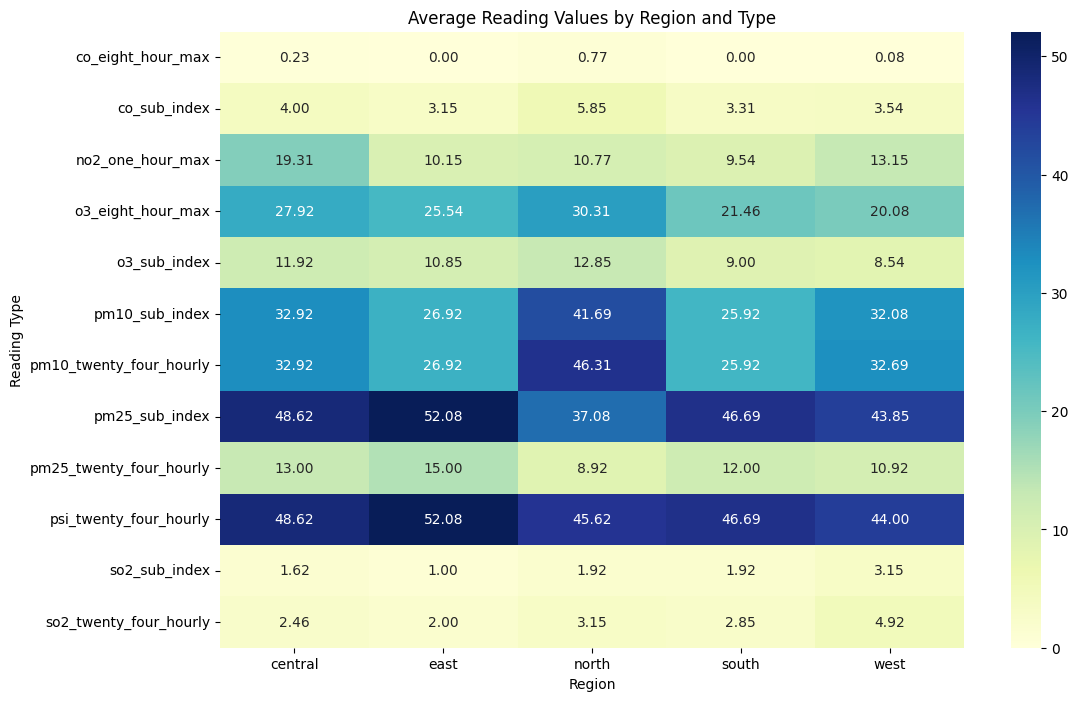

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

avg_readings = sg_psi_df.groupby(['reading_type','region'])['reading_value'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(avg_readings, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title('Average Reading Values by Region and Type')
plt.ylabel('Reading Type')
plt.xlabel('Region')
plt.show()

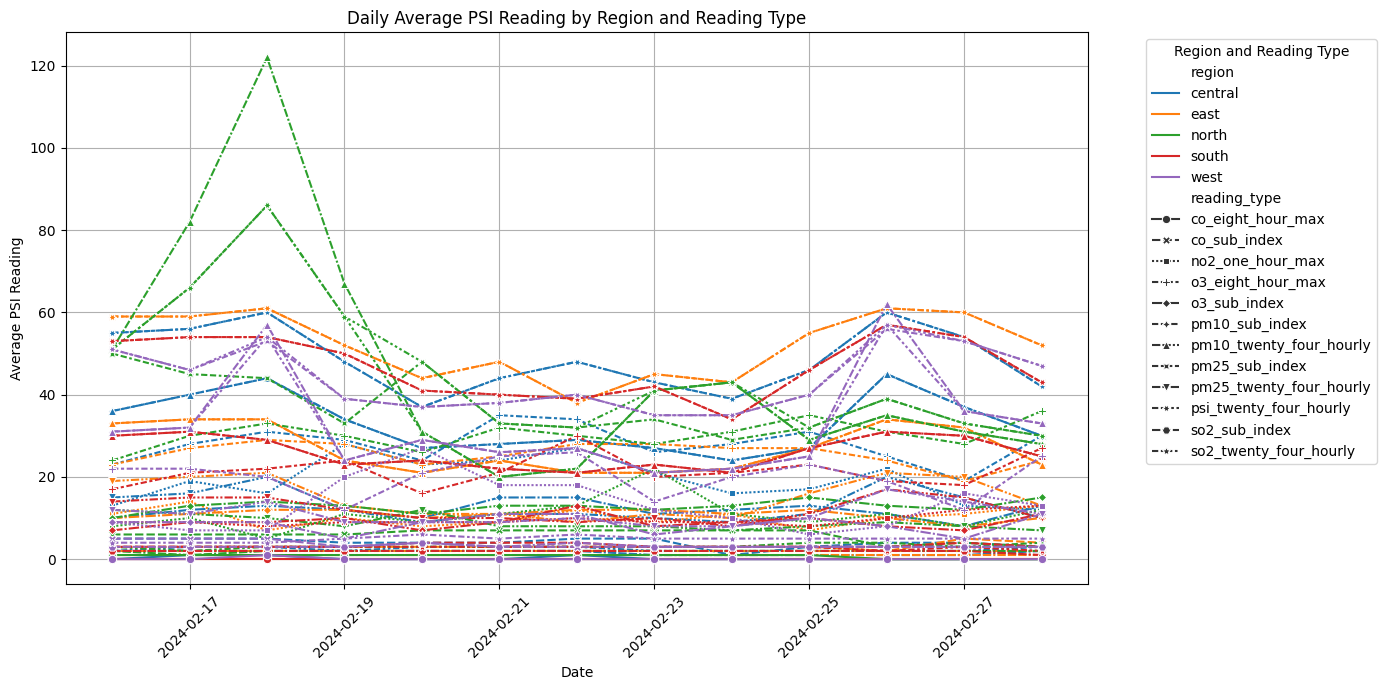

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


daily_average_psi = sg_psi_df.groupby(['date', 'region', 'reading_type'])['reading_value'].mean().reset_index()


plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_average_psi, x='date', y='reading_value', hue='region', style='reading_type', markers=True)
plt.title('Daily Average PSI Reading by Region and Reading Type')
plt.xlabel('Date')
plt.ylabel('Average PSI Reading')
plt.xticks(rotation=45)
plt.legend(title='Region and Reading Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


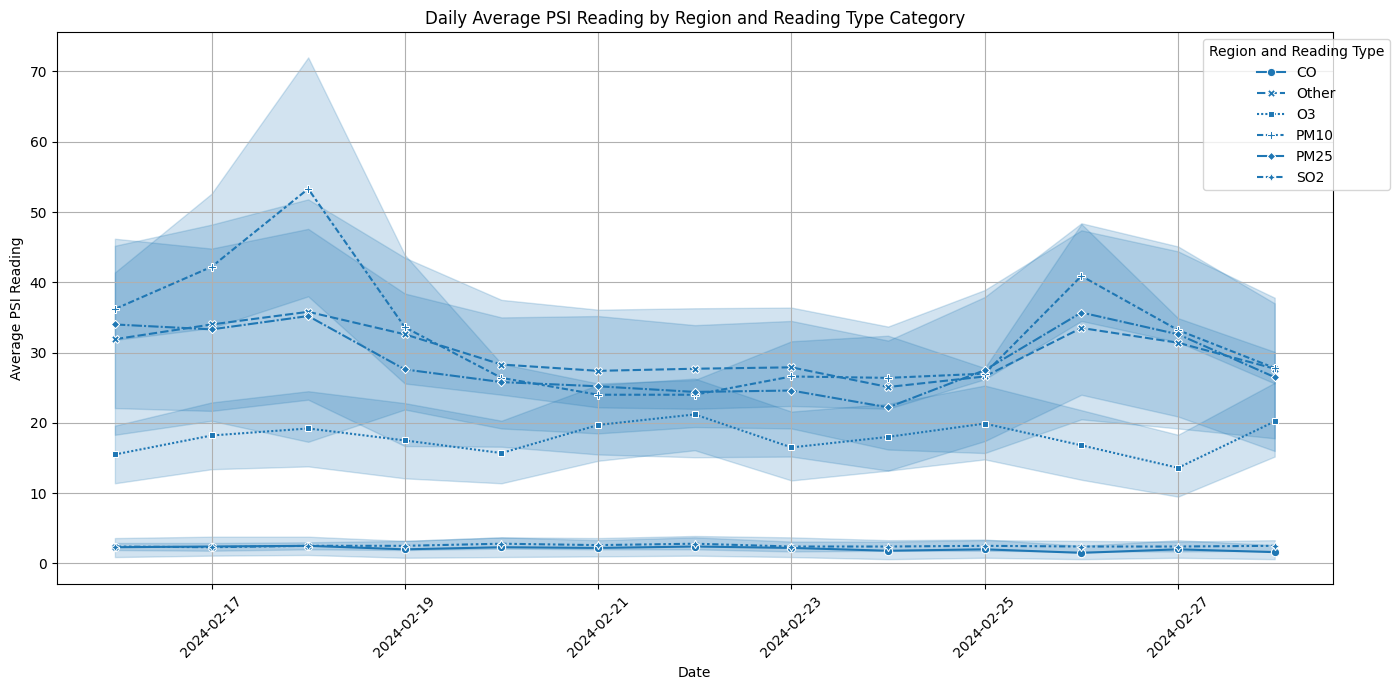

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


daily_average_psi = sg_psi_df.groupby(['date', 'region', 'reading_type'])['reading_value'].mean().reset_index()

def categorize_reading_type(reading_type):
    if reading_type.startswith('co'):
        return 'CO'
    elif reading_type.startswith('o3'):
        return 'O3'
    elif reading_type.startswith('pm10'):
        return 'PM10'
    elif reading_type.startswith('pm25'):
        return 'PM25'
    elif reading_type.startswith('so2'):
        return 'SO2'
    else:
        return 'Other'


daily_average_psi['category'] = daily_average_psi['reading_type'].apply(categorize_reading_type)

plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_average_psi, 
             x='date', 
             y='reading_value', 
             style='category', 
             markers=True)

plt.title('Daily Average PSI Reading by Region and Reading Type Category')
plt.xlabel('Date')
plt.ylabel('Average PSI Reading')
plt.xticks(rotation=45)
plt.legend(title='Region and Reading Type', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()


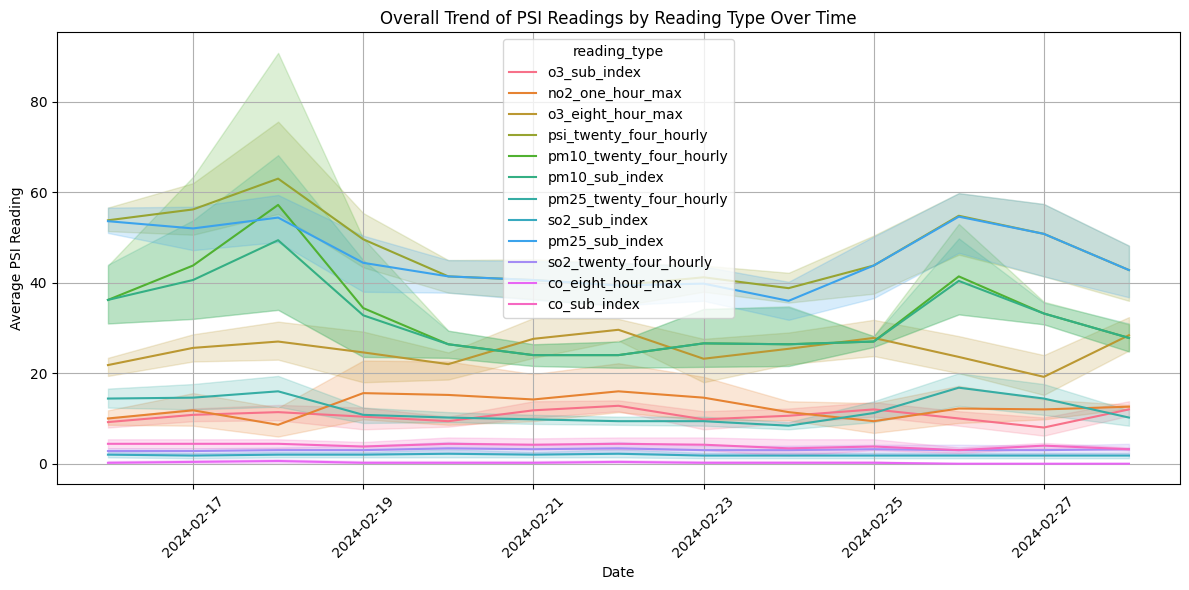

In [11]:
# Plotting the overall trend of PSI readings by reading type over the date range
plt.figure(figsize=(12, 6))
sns.lineplot(data=sg_psi_df, x='date', y='reading_value', hue='reading_type', estimator='mean', markers=True)
plt.title('Overall Trend of PSI Readings by Reading Type Over Time')
plt.xlabel('Date')
plt.ylabel('Average PSI Reading')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


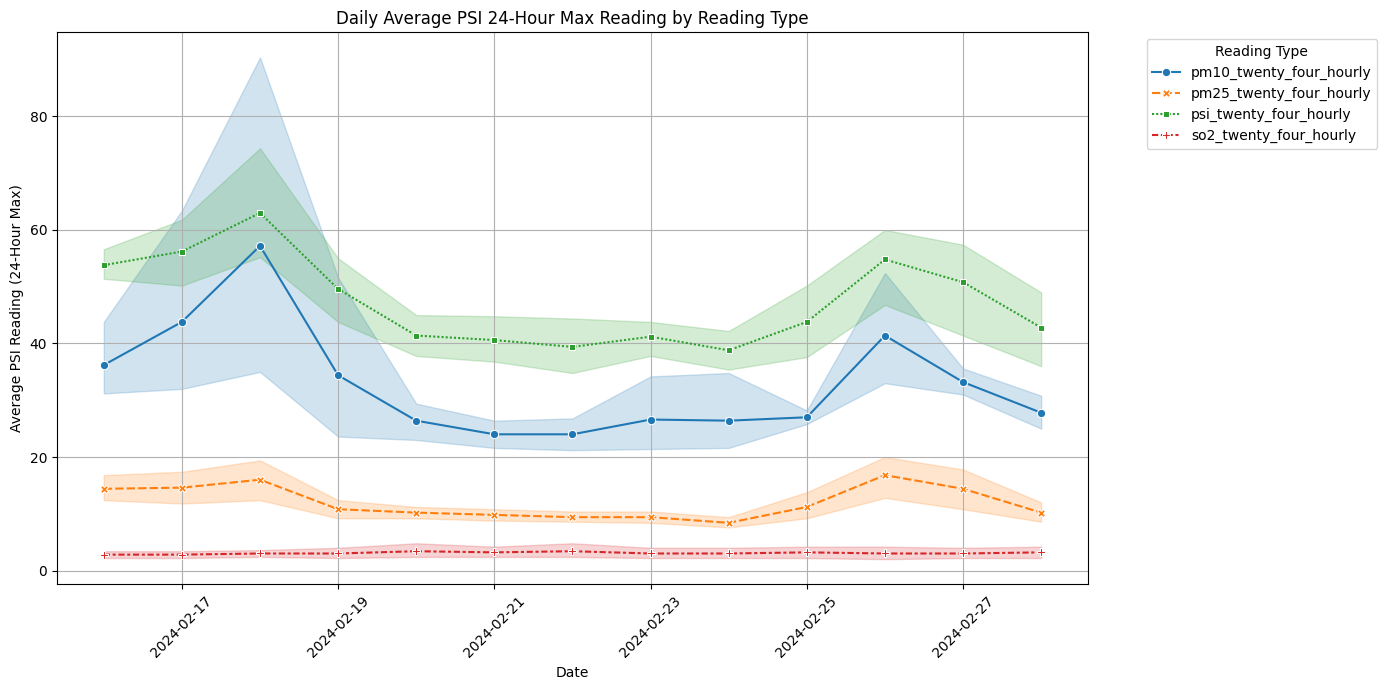

In [12]:
# only use data for 24-hour max readings
filtered_sg_air_data = daily_average_psi[daily_average_psi['reading_type'].str.contains('twenty_four_hourly')]


plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_sg_air_data, 
             x='date', 
             y='reading_value', 
             style='reading_type', 
             hue='reading_type',
             markers=True)

plt.title('Daily Average PSI 24-Hour Max Reading by Reading Type')
plt.xlabel('Date')
plt.ylabel('Average PSI Reading (24-Hour Max)')
plt.xticks(rotation=45)
plt.legend(title='Reading Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()

# Show plot
plt.show()


In [13]:
print(hk_traffic_df.describe())

                                date         speed     occupancy  \
count                          35804  35804.000000  35804.000000   
mean   2024-02-22 14:25:16.255166976     43.836052      5.856133   
min              2024-02-16 00:00:00      0.000000      0.000000   
25%              2024-02-19 00:00:00     34.000000      0.000000   
50%              2024-02-23 00:00:00     50.000000      2.000000   
75%              2024-02-26 00:00:00     50.000000      8.000000   
max              2024-02-29 00:00:00    172.000000     93.000000   
std                              NaN     12.904477      8.698036   

             volume       std_dev  
count  35804.000000  35804.000000  
mean       1.270445      1.532731  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      0.000000  
75%        2.000000      1.700000  
max       15.000000     77.800000  
std        1.788407      3.604019  



Date with the largest volume:
Date: 2024-02-28 00:00:00, Volume: 15, Detector ID: AID20059


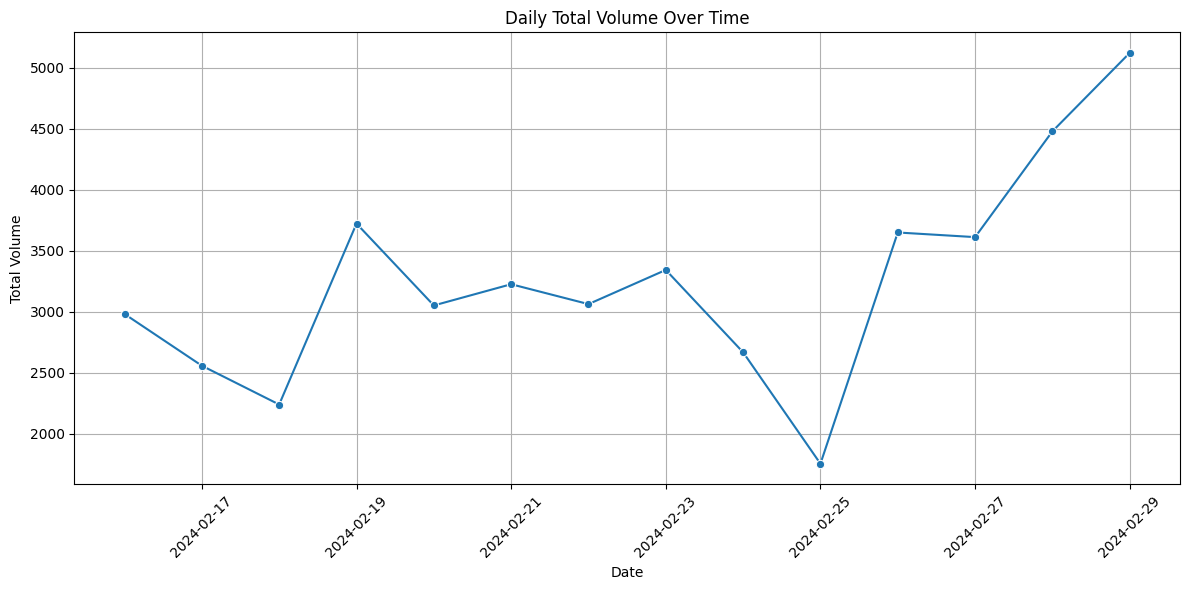

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Finding the date with the largest volume
max_volume_row = hk_traffic_df.loc[hk_traffic_df['volume'].idxmax()]
print("\nDate with the largest volume:")
print(f"Date: {max_volume_row['date']}, Volume: {max_volume_row['volume']}, Detector ID: {max_volume_row['detector_id']}")

# Grouping by date to analyze total volume per day
daily_volume = hk_traffic_df.groupby('date')['volume'].sum().reset_index()

# Plotting daily volume over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_volume, x='date', y='volume', marker='o')
plt.title('Daily Total Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

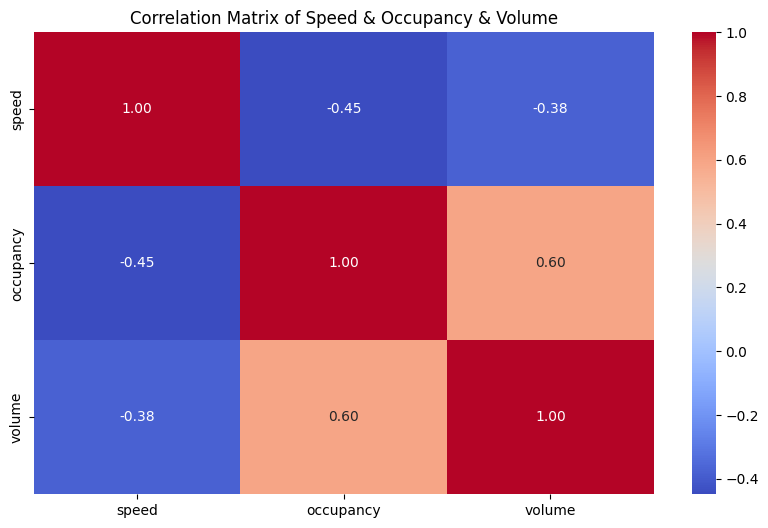

In [15]:
# Calculate correlation matrix
correlation_matrix = hk_traffic_df[['speed', 'occupancy', 'volume']].corr()

# Plotting heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Speed & Occupancy & Volume')
plt.show()

## 4. Data Modelling and Analysis

## 5. Comparative Analysis

## 6. Conclusions and Recommendations

## 7. References

## 8. API URLs